### Spaceship Titanic with fastai

Competition [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In [1]:
#|default_exp app

In [2]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.tabular.all import *
from fastbook import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

from dtreeviz.trees import *
import dtreeviz

from IPython.display import Image, display_svg, SVG

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('spaceship-titanic')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/spaceship-titanic')
    ! pip install -q dataset

Import CSV's as Pandas Dataframes

In [9]:
#| export
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [10]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### Infer Cryosleep NaN by Amenities Use

In [11]:
df['CryoSleep'].isnull().count

<bound method Series.count of 0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689    False
8690    False
8691    False
8692    False
Name: CryoSleep, Length: 8693, dtype: bool>

In [12]:
df[np.where(df['CryoSleep'] == True, True, False)].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
18,0016_01,Mars,True,F/5/P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,Alus Upead,True
21,0020_01,Earth,True,E/0/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Almary Brantuarez,False


In [13]:
df[np.where(df['CryoSleep'] == True, True, False)].shape

(3037, 14)

In [14]:
cryo_amenities_df = ['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [15]:
null_cryo_df = df.loc[df['CryoSleep'].isnull(), cryo_amenities_df]
test_null_cryo_df = test_df.loc[df['CryoSleep'].isnull(), cryo_amenities_df]

In [16]:
df['CryoSleep'].isnull().sum()

217

In [17]:
null_cryo_df

,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
92,NaN,0.0,0.0,0.0,0.0,0.0
98,NaN,0.0,0.0,570.0,2.0,131.0
104,NaN,0.0,331.0,0.0,0.0,1687.0
111,NaN,0.0,0.0,0.0,0.0,NaN
152,NaN,0.0,985.0,0.0,5.0,0.0
...,...,...,...,...,...,...
8620,NaN,0.0,0.0,0.0,0.0,0.0
8651,NaN,0.0,0.0,0.0,0.0,0.0
8664,NaN,0.0,0.0,0.0,0.0,0.0
8675,NaN,1030.0,1015.0,0.0,11.0,NaN


here

In [18]:
amenities_mask =(null_cryo_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] > 0).any(axis=1)
test_amenities_mask =(test_null_cryo_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] > 0).any(axis=1)
amenities_mask

92      False
98       True
104      True
111     False
152      True
        ...  
8620    False
8651    False
8664    False
8675     True
8687     True
Length: 217, dtype: bool

In [19]:
df.loc[null_cryo_df.index, cryo_amenities_df].head(), df.loc[null_cryo_df.index, cryo_amenities_df].shape

(    CryoSleep  RoomService  FoodCourt  ShoppingMall  Spa  VRDeck
 92        NaN          0.0        0.0           0.0  0.0     0.0
 98        NaN          0.0        0.0         570.0  2.0   131.0
 104       NaN          0.0      331.0           0.0  0.0  1687.0
 111       NaN          0.0        0.0           0.0  0.0     NaN
 152       NaN          0.0      985.0           0.0  5.0     0.0,
 (217, 6))

In [20]:
df.loc[null_cryo_df.index, 'CryoSleep']

92      NaN
98      NaN
104     NaN
111     NaN
152     NaN
       ... 
8620    NaN
8651    NaN
8664    NaN
8675    NaN
8687    NaN
Name: CryoSleep, Length: 217, dtype: object

In [21]:
df.loc[null_cryo_df.index, 'CryoSleep'] = np.where(amenities_mask, False, True)
test_df.loc[test_null_cryo_df.index, 'CryoSleep'] = np.where(test_amenities_mask, False, True)

In [22]:
df['CryoSleep'].isnull().sum()

0

#### Replace NaN Amenities Values with 0

In [23]:
df['RoomService'].isnull().sum()

181

In [24]:
test_df.shape

(4277, 13)

In [25]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [26]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isnull().sum()

RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [27]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [28]:
df[amenities] = df[amenities].fillna(0)
test_df[amenities] = test_df[amenities].fillna(0)

#### Names to Surnames

This name on such a small dataset could cause overfitting, so I'm going to try splitting into families by last name. I'll also be dropping `Name` as a category afterward

In [29]:
df['surname'] = df['Name'].str.split(' ').str[1]

In [30]:
test_df['surname'] = test_df['Name'].str.split(' ').str[1]

In [31]:
df = df.drop(['Name'], axis=1)

In [32]:
test_df = test_df.drop(['Name'], axis=1)

#### Split PassengerId and Room

Looking at this there's some extra data we can extract to new columns, *PassengerId* looks like it's by group number and the number in a particular group, split with an underscore `_` 

In [33]:
df['group_num'] = df['PassengerId'].str.split('_').str[0]
df['num_w_in_group'] = df['PassengerId'].str.split('_').str[1]

In [34]:
test_df['group_num'] =test_df['PassengerId'].str.split('_').str[0]
test_df['num_w_in_group'] =test_df['PassengerId'].str.split('_').str[1]

The same is true for the Cabin, there are 3 different values to analyze here, so let's split them up as well

In [35]:
df['deck'] = df['Cabin'].str.split('/').str[0]
df['room_num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

In [36]:
test_df['deck'] = test_df['Cabin'].str.split('/').str[0]
test_df['room_num'] = test_df['Cabin'].str.split('/').str[1]
test_df['side'] = test_df['Cabin'].str.split('/').str[2]

Take the max number of the last two digits in PassengerId given that the first four numbers are the same

In [37]:
df['num_w_in_group'] = df['num_w_in_group'].astype(int)

In [38]:
test_df['num_w_in_group'] = test_df['num_w_in_group'].astype(int)

In [39]:
max_num_in_group = df.groupby('group_num')['num_w_in_group'].max().astype(int)

In [40]:
test_max_num_in_group = test_df.groupby('group_num')['num_w_in_group'].max().astype(int)

In [41]:
len(max_num_in_group)

6217

In [42]:
max_num_in_group.head()

group_num
0001    1
0002    1
0003    2
0004    1
0005    1
Name: num_w_in_group, dtype: int64

In [43]:
df['num_in_group'] = df['group_num'].map(max_num_in_group)

In [44]:
test_df['num_in_group'] = test_df['group_num'].map(test_max_num_in_group)

In [45]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1


Finding if everyone boarding is a family group or not by last name:
- Find if the count of family group == num_in_group

In [46]:
boarded_together = df.groupby('surname')['num_in_group'].nunique() == 1

In [47]:
test_boarded_together = test_df.groupby('surname')['num_in_group'].nunique() == 1

In [48]:
df['fam_board_together'] = df['surname'].map(boarded_together)

In [49]:
test_df['fam_board_together'] = test_df['surname'].map(test_boarded_together)

In [50]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1,False


In [51]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Carsoning,0013,1,G,3,S,1,False
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Peckers,0018,1,F,4,S,1,True
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Unhearfus,0019,1,C,0,S,1,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Caltilter,0021,1,C,1,S,1,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Harperez,0023,1,F,5,S,1,True


#### Replace NaN Home and Destination with Group Values

In [52]:
df.loc[np.where(df['HomePlanet'].isnull())]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,True,Keen,0064,2,E,3,S,2,True
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,False,Coning,0119,1,A,0,P,2,False
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,0.0,0.0,0.0,True,Inicont,0210,1,D,6,P,1,False
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,False,Sté,0242,1,F,46,S,1,True
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,True,Amsive,0251,1,C,11,S,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,9084_01,NaN,False,E/582/P,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,False,Mone,9084,1,E,582,P,1,False
8613,9194_01,NaN,False,E/603/S,55 Cancri e,53.0,False,0.0,4017.0,0.0,13.0,3147.0,False,NaN,9194,1,E,603,S,2,NaN
8666,9248_01,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,True,Perle,9248,1,F,1792,S,1,False
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,False,Apple,9257,1,F,1892,P,1,True


In [53]:
df.groupby('group_num')['HomePlanet'].value_counts()

group_num  HomePlanet
0001       Europa        1
0002       Earth         1
0003       Europa        2
0004       Earth         1
0005       Earth         1
                        ..
9275       Europa        3
9276       Europa        1
9278       Earth         1
9279       Earth         1
9280       Europa        2
Name: HomePlanet, Length: 6107, dtype: int64

In [54]:
mode_planet = df.groupby('group_num')['HomePlanet'].apply(lambda x: x.mode(dropna=True))

In [55]:
mode_planet

group_num   
0001       0    Europa
0002       0     Earth
0003       0    Europa
0004       0     Earth
0005       0     Earth
                 ...  
9275       0    Europa
9276       0    Europa
9278       0     Earth
9279       0     Earth
9280       0    Europa
Name: HomePlanet, Length: 6107, dtype: object

In [56]:
np.where(df['HomePlanet'].isnull())

(array([  59,  113,  186,  225,  234,  274,  286,  291,  347,  365,  405,  407,  438,  471,  481,  501,  505,  524,  568,  637,  737,  807,  848,  920,  962,  993,  999, 1004, 1024, 1267, 1307, 1392,
        1399, 1550, 1600, 1706, 1714, 1757, 1807, 1855, 1892, 1916, 1926, 2166, 2173, 2227, 2233, 2246, 2274, 2281, 2290, 2322, 2324, 2425, 2442, 2461, 2502, 2544, 2617, 2630, 2631, 2638, 2642, 2715,
        2749, 2773, 2791, 2898, 2926, 2969, 3091, 3119, 3168, 3192, 3277, 3281, 3326, 3370, 3433, 3503, 3535, 3560, 3595, 3622, 3635, 3769, 3816, 3858, 3891, 3940, 3946, 3951, 4025, 4089, 4097, 4154,
        4172, 4230, 4315, 4343, 4366, 4374, 4535, 4548, 4581, 4632, 4702, 4770, 4817, 4861, 5016, 5024, 5055, 5079, 5081, 5096, 5101, 5112, 5208, 5252, 5316, 5427, 5438, 5465, 5576, 5624, 5634, 5687,
        5689, 5699, 5723, 5762, 5904, 5906, 5953, 5988, 6004, 6011, 6030, 6054, 6056, 6154, 6169, 6197, 6205, 6257, 6267, 6450, 6565, 6591, 6609, 6616, 6622, 6629, 6644, 6735, 6737, 6854, 6913, 6917,


In [57]:
df.groupby('group_num')['HomePlanet'].size()

group_num
0001    1
0002    1
0003    2
0004    1
0005    1
       ..
9275    3
9276    1
9278    1
9279    1
9280    2
Name: HomePlanet, Length: 6217, dtype: int64

In [58]:
df.groupby('group_num')['HomePlanet'].size().to_frame('counts')

,counts
group_num,
0001,1
0002,1
0003,2
0004,1
0005,1
...,...
9275,3
9276,1
9278,1


In [59]:
df.groupby('group_num')['HomePlanet'].size().to_frame('counts').reset_index()

,group_num,counts
0,0001,1
1,0002,1
2,0003,2
3,0004,1
4,0005,1
...,...,...
6212,9275,3
6213,9276,1
6214,9278,1
6215,9279,1


In [60]:
df.groupby('group_num')['HomePlanet'].size().to_frame('counts').reset_index().sort_values('counts')

,group_num,counts
0,0001,1
3872,5751,1
3871,5750,1
3870,5748,1
3869,5747,1
...,...,...
654,0984,8
3023,4498,8
2858,4256,8
5893,8796,8


In [61]:
df.groupby('group_num')['HomePlanet'].size().to_frame('counts').reset_index().sort_values('counts', ascending=False)

,group_num,counts
3023,4498,8
5487,8168,8
5851,8728,8
5893,8796,8
6000,8956,8
...,...,...
2334,3483,1
2333,3480,1
2332,3478,1
2328,3473,1


In [62]:
df.groupby('group_num')['HomePlanet'].size().to_frame('counts') \
  .reset_index().sort_values('counts', ascending=False) \
  .drop_duplicates()

,group_num,counts
3023,4498,8
5487,8168,8
5851,8728,8
5893,8796,8
6000,8956,8
...,...,...
2334,3483,1
2333,3480,1
2332,3478,1
2328,3473,1


In [63]:
df.groupby('group_num')['HomePlanet'].size().to_frame('counts') \
  .reset_index().sort_values('counts', ascending=False) \
  .drop_duplicates(subset='group_num')

,group_num,counts
3023,4498,8
5487,8168,8
5851,8728,8
5893,8796,8
6000,8956,8
...,...,...
2334,3483,1
2333,3480,1
2332,3478,1
2328,3473,1


In [64]:
df.groupby('group_num')['HomePlanet'].size().to_frame('counts') \
  .reset_index().sort_values('counts', ascending=False) \
  .drop_duplicates(subset='group_num').drop(columns='counts')

,group_num
3023,4498
5487,8168
5851,8728
5893,8796
6000,8956
...,...
2334,3483
2333,3480
2332,3478
2328,3473


In [65]:
mode_planet.head()

group_num   
0001       0    Europa
0002       0     Earth
0003       0    Europa
0004       0     Earth
0005       0     Earth
Name: HomePlanet, dtype: object

In [66]:
# create a function to replace NaN values with mode values
def fillna_mode(group):
    mode_series = group['HomePlanet'].mode()
    if mode_series.empty:
        # if mode Series is empty, return the original group
        return group
    else:
        # otherwise, fill NaN values with the mode value
        mode_value = mode_series[0]
        group['HomePlanet'].fillna(mode_value, inplace=True)
        return group


In [67]:
# apply the function to each group
df = df.groupby('group_num', group_keys=False).apply(fillna_mode)

In [68]:
df.head(n=5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1,False


In [69]:
df['HomePlanet'].isnull().sum()

111

#### Check Nulls

In [70]:
def get_null_counts(df):
    null_count_df = pd.DataFrame((df.isnull().sum()).sort_values(ascending=False).reset_index())
    null_count_df.columns = ['column_name','null_counts']
    null_count_df = null_count_df.query("column_name!='Transported'")
    return null_count_df

null_= get_null_counts(df)
null_.style.background_gradient(cmap='summer')

,column_name,null_counts
0,VIP,203
1,fam_board_together,200
2,surname,200
3,Cabin,199
4,side,199
5,room_num,199
6,deck,199
7,Destination,182
8,Age,179
9,HomePlanet,111


In [71]:
test_null = get_null_counts(test_df)
null_.style.background_gradient(cmap='winter')

,column_name,null_counts
0,VIP,203
1,fam_board_together,200
2,surname,200
3,Cabin,199
4,side,199
5,room_num,199
6,deck,199
7,Destination,182
8,Age,179
9,HomePlanet,111


Boolean values converted to 0's and 1's

In [72]:
def bool_switch(df, col_name):
    encoder = LabelEncoder()
    df[f'{col_name}'] = encoder.fit_transform(df[f'{col_name}']) 

In [73]:
bool_switch(df, col_name='Transported')
bool_switch(df, col_name='VIP')
bool_switch(df, col_name='CryoSleep')
bool_switch(df, col_name="fam_board_together")

In [74]:
df.shape

(8693, 21)

In [75]:
bool_switch(test_df, col_name='VIP')
bool_switch(test_df, col_name='CryoSleep')
bool_switch(test_df, col_name="fam_board_together")

In [76]:
test_df.shape

(4277, 20)

### Preparing Data

Declare dependant variable(y-axis)

In [77]:
#| export
dep_var = 'Transported'

In [78]:
df['Destination'].sample

<bound method NDFrame.sample of 0         TRAPPIST-1e
1         TRAPPIST-1e
2         TRAPPIST-1e
3         TRAPPIST-1e
4         TRAPPIST-1e
            ...      
8688      55 Cancri e
8689    PSO J318.5-22
8690      TRAPPIST-1e
8691      55 Cancri e
8692      TRAPPIST-1e
Name: Destination, Length: 8693, dtype: object>

Add tabular processes to transform categorical variables to something similar to `pd.Categorical`, and fill in missing/na values

In [79]:
#| export
procs = [Categorify, FillMissing, Normalize]

In [80]:
#| export
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [81]:
test_cont, test_cat = cont_cat_split(test_df, 1, dep_var=dep_var)

In [82]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, 
                    y_block=CategoryBlock(), 
                    splits=RandomSplitter(valid_pct=0.2, seed=42)(df)).dataloaders(bs=128)

In [83]:
to.fill_strategy

'median'

In [84]:
test_to = TabularPandas(test_df, procs, test_cat, test_cont, y_names=None, 
                    y_block=CategoryBlock(), 
                    splits=None).dataloaders(bs=128)

In [85]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [86]:
test_xs = test_to.train.xs

In [87]:
xs.head()

,PassengerId,HomePlanet,Cabin,Destination,surname,group_num,deck,room_num,side,Age_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num_w_in_group,num_in_group,fam_board_together
8388,8389,3,3242,3,300,6005,6,786,2,1,-0.759434,1.612332,-0.206029,1.470626,-0.282769,-0.267182,-0.267988,-0.263122,-0.493406,-0.652869,1.123458
1917,1918,1,5560,3,0,1362,7,1078,1,1,1.316770,-0.265485,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,1.383858,2.463179,2.994542
5173,5174,1,6379,2,1504,3719,7,1692,1,1,-0.759434,0.012710,-0.206029,-0.327109,-0.284032,-0.246835,-0.267988,0.100366,-0.493406,-0.652869,1.123458
8246,8247,1,2091,2,870,5905,5,1351,2,1,-0.759434,2.377369,-0.206029,-0.327109,-0.284032,-0.145103,-0.267988,1.836428,-0.493406,-0.652869,1.123458
61,62,1,4563,2,1186,44,7,3,2,1,1.316770,-2.004205,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,-0.493406,0.593550,-0.747627


In [88]:
xs.shape

(6955, 21)

In [89]:
test_xs.head()

,PassengerId,HomePlanet,Cabin,Destination,surname,group_num,deck,room_num,side,Age_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num_w_in_group,num_in_group,fam_board_together
0,1,1,2785,3,276,1,7,821,2,1,1.116077,-0.114147,-0.191678,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-0.489847,-0.648973,-1.116345
1,2,1,1868,3,1191,2,6,928,2,1,-0.760284,-0.684313,-0.191678,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,-0.489847,-0.648973,0.757520
2,3,2,258,1,1605,3,3,1,2,1,1.116077,0.170937,-0.191678,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,-0.489847,-0.648973,0.757520
3,4,2,260,3,263,4,3,2,2,1,-0.760284,0.669832,-0.191678,-0.357339,4.121518,-0.312173,-0.104002,0.226648,-0.489847,-0.648973,0.757520
4,5,1,1941,3,737,5,6,1030,2,1,-0.760284,-0.613042,-0.191678,-0.340723,-0.283840,0.832122,-0.267841,-0.246712,-0.489847,-0.648973,0.757520


In [90]:
test_xs.shape

(4277, 21)

/tmp/ipykernel_24022/3888966817.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

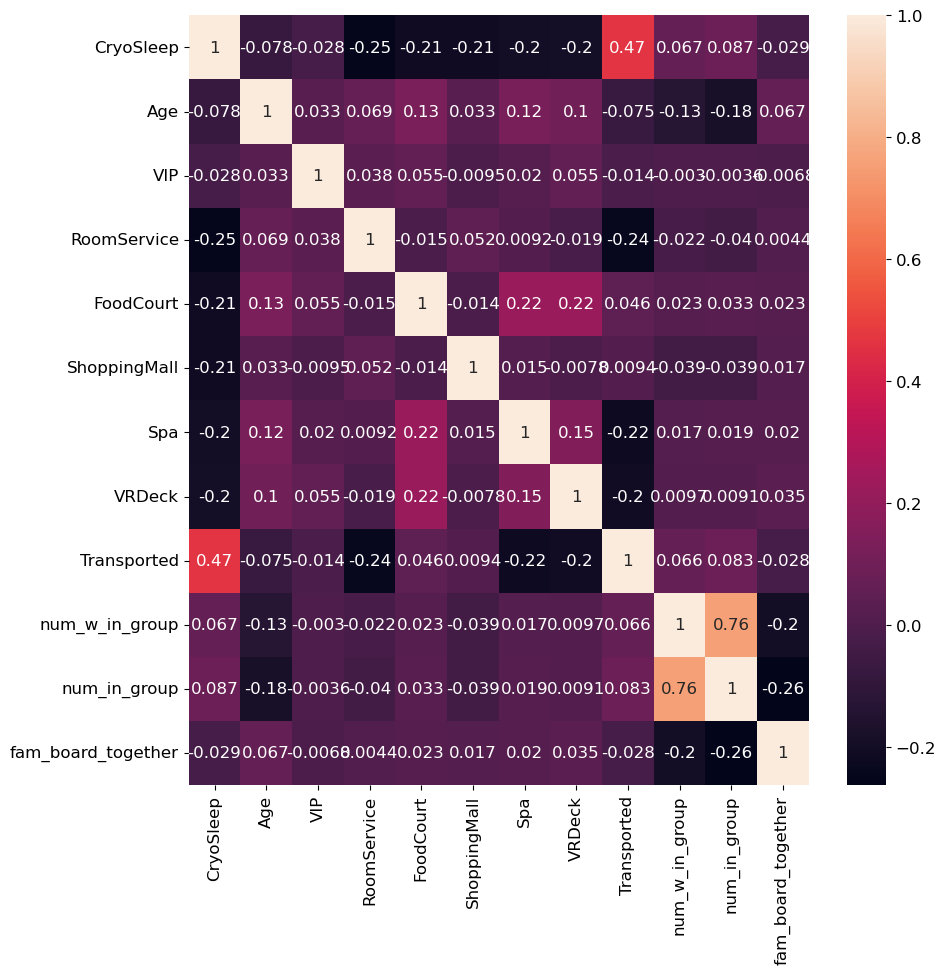

In [91]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [92]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, min_samples_leaf=min_samples_leaf, 
        oob_score=True).fit(xs,y)

In [93]:
m = rf(xs,y)

In [94]:
def pred_acc(m, valid_xs=valid_xs):
    y_pred = m.predict(valid_xs)
    accuracy = accuracy_score(valid_y, y_pred)
    return accuracy

In [95]:
pred_acc(m)

0.8049482163406214

In [96]:
def rf_feat_importances(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [97]:
fi = rf_feat_importances(m, xs)
fi

,cols,imp
10,CryoSleep,0.198063
13,RoomService,0.094488
16,Spa,0.093951
17,VRDeck,0.081014
2,Cabin,0.074576
14,FoodCourt,0.073532
11,Age,0.055824
7,room_num,0.046454
4,surname,0.043804
15,ShoppingMall,0.043773


In [98]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot: ylabel='cols'>

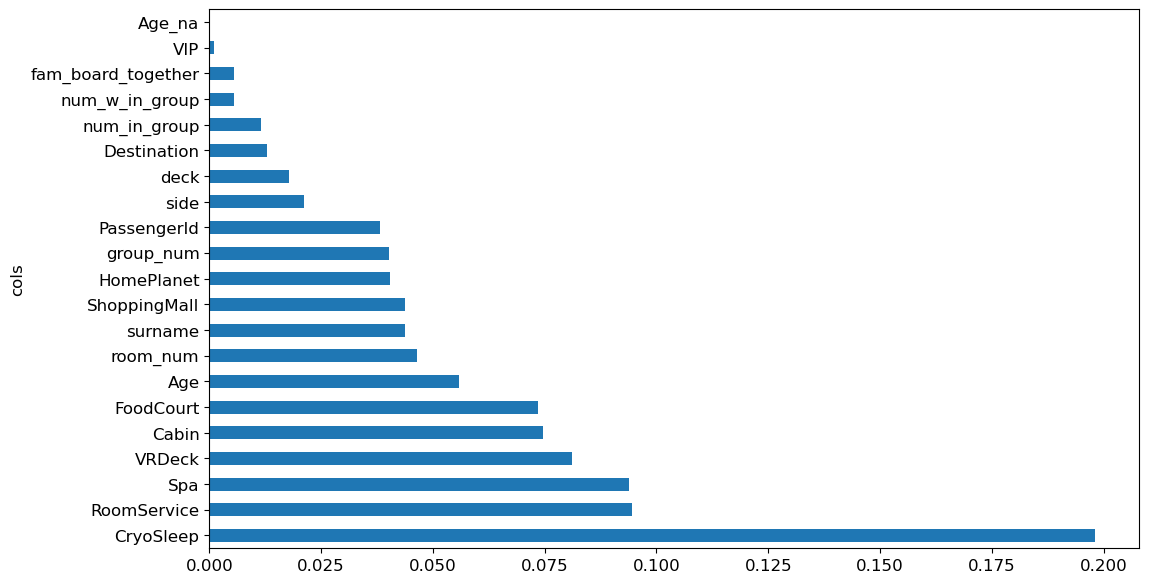

In [99]:
plot_fi(fi)

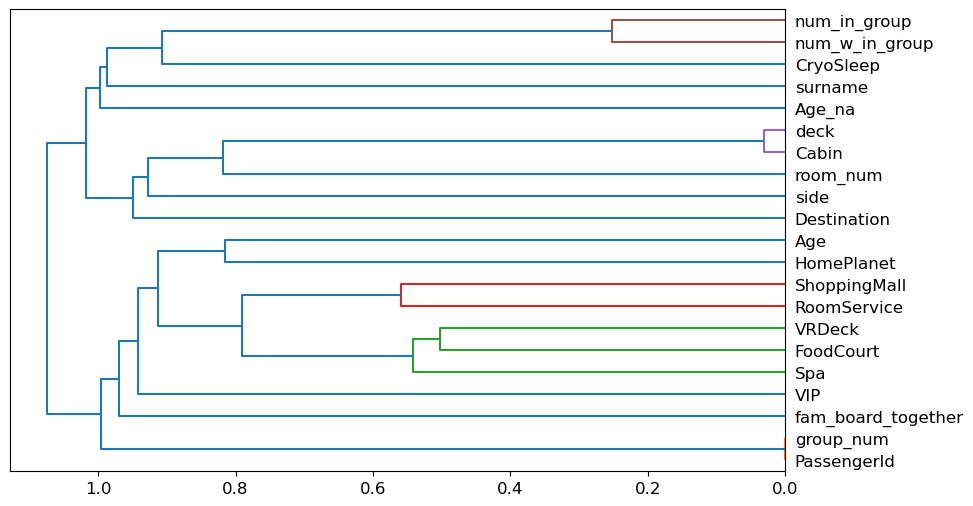

In [100]:
cluster_columns(xs)

In [101]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep), len(fi)

(19, 21)

In [102]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [103]:
test_xs_imp = test_xs[to_keep]

In [104]:
len(test_xs_imp)

4277

In [105]:
m = rf(xs_imp, y)

In [106]:
pred_acc(m, valid_xs=valid_xs_imp)

0.806674338319908

<AxesSubplot: ylabel='cols'>

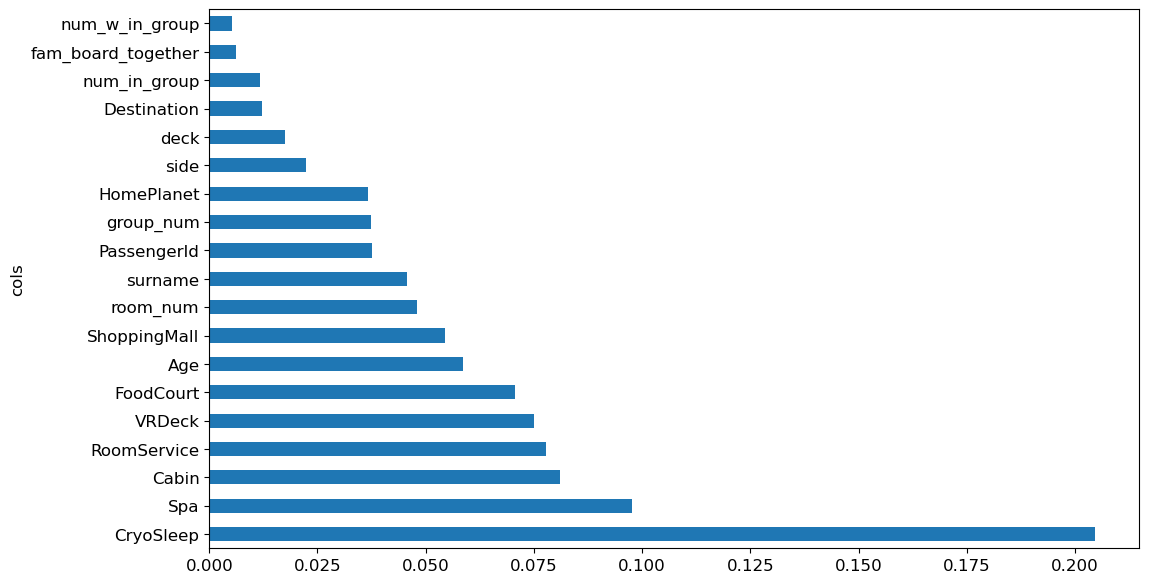

In [107]:
plot_fi(rf_feat_importances(m, xs_imp))

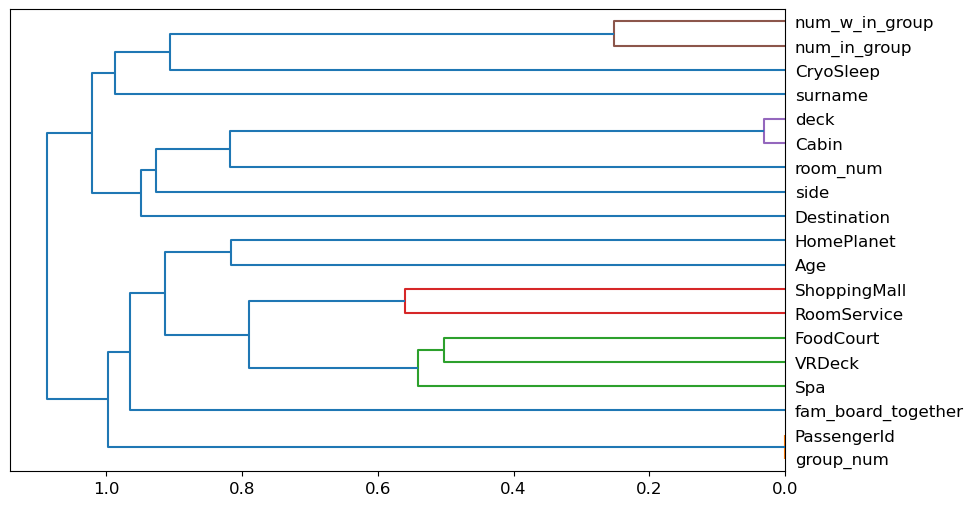

In [108]:
cluster_columns(xs_imp)

In [109]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [110]:
get_oob(xs_imp)


0.7968368080517613

In [111]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in xs_imp.columns}

{'CryoSleep': 0.7941049604601006,
 'RoomService': 0.7906542056074767,
 'Spa': 0.7784327821710999,
 'VRDeck': 0.7856218547807333,
 'Cabin': 0.792235801581596,
 'FoodCourt': 0.7915168943206327,
 'Age': 0.793961179007908,
 'room_num': 0.794392523364486,
 'surname': 0.7998562185478073,
 'ShoppingMall': 0.7902228612508987,
 'HomePlanet': 0.7933860531991374,
 'group_num': 0.794392523364486,
 'PassengerId': 0.7936736161035226,
 'side': 0.793098490294752,
 'deck': 0.7964054636951833,
 'Destination': 0.7941049604601006,
 'num_in_group': 0.7958303378864127,
 'num_w_in_group': 0.7932422717469446,
 'fam_board_together': 0.7941049604601006}

In [112]:
{c:get_oob(xs.drop(c, axis=1)) for c in xs.columns}

{'PassengerId': 0.7910855499640547,
 'HomePlanet': 0.796980589503954,
 'Cabin': 0.7923795830337886,
 'Destination': 0.7953989935298347,
 'surname': 0.7928109273903666,
 'group_num': 0.7994248741912293,
 'deck': 0.7952552120776419,
 'room_num': 0.7928109273903666,
 'side': 0.7903666427030913,
 'Age_na': 0.7959741193386053,
 'CryoSleep': 0.7915168943206327,
 'Age': 0.7920920201294033,
 'VIP': 0.7955427749820273,
 'RoomService': 0.7906542056074767,
 'FoodCourt': 0.784040258806614,
 'ShoppingMall': 0.7912293314162473,
 'Spa': 0.7833213515456506,
 'VRDeck': 0.7847591660675772,
 'num_w_in_group': 0.798705966930266,
 'num_in_group': 0.7936736161035226,
 'fam_board_together': 0.7975557153127246}

In [113]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [114]:
test_xs_final = test_xs_imp

In [115]:
xs_final.head()

,CryoSleep,RoomService,Spa,VRDeck,Cabin,FoodCourt,Age,room_num,surname,ShoppingMall,HomePlanet,group_num,PassengerId,side,deck,Destination,num_in_group,num_w_in_group,fam_board_together
8388,-0.759434,1.470626,-0.267988,-0.263122,3242,-0.282769,1.612332,786,300,-0.267182,3,6005,8389,2,6,3,-0.652869,-0.493406,1.123458
1917,1.316770,-0.327109,-0.267988,-0.263122,5560,-0.284032,-0.265485,1078,0,-0.280746,1,1362,1918,1,7,3,2.463179,1.383858,2.994542
5173,-0.759434,-0.327109,-0.267988,0.100366,6379,-0.284032,0.012710,1692,1504,-0.246835,1,3719,5174,1,7,2,-0.652869,-0.493406,1.123458
8246,-0.759434,-0.327109,-0.267988,1.836428,2091,-0.284032,2.377369,1351,870,-0.145103,1,5905,8247,2,5,2,-0.652869,-0.493406,1.123458
61,1.316770,-0.327109,-0.267988,-0.263122,4563,-0.284032,-2.004205,3,1186,-0.280746,1,44,62,2,7,2,0.593550,-0.493406,-0.747627


In [116]:
pred_acc(m, valid_xs=valid_xs_final)

0.806674338319908

In [117]:
valid_xs_final.columns

Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'Cabin', 'FoodCourt',
       'Age', 'room_num', 'surname', 'ShoppingMall', 'HomePlanet', 'group_num',
       'PassengerId', 'side', 'deck', 'Destination', 'num_in_group',
       'num_w_in_group', 'fam_board_together'],
      dtype='object')

In [118]:
# test_xs = [test_xs.drop([x], axis=1) for x in test_xs if x not in valid_xs_final]

In [119]:
# for x in test_xs.columns:
#     if x not in valid_xs_final.columns:
#         test_xs = test_xs.drop([x], axis=1)

In [120]:
len(test_xs_final)

4277

In [121]:
len(test_xs.columns), len(valid_xs_final.columns)

(21, 19)

In [122]:
test_xs.columns, valid_xs_final.columns

(Index(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'surname',
        'group_num', 'deck', 'room_num', 'side', 'Age_na', 'CryoSleep', 'Age',
        'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'num_w_in_group', 'num_in_group', 'fam_board_together'],
       dtype='object'),
 Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'Cabin', 'FoodCourt',
        'Age', 'room_num', 'surname', 'ShoppingMall', 'HomePlanet', 'group_num',
        'PassengerId', 'side', 'deck', 'Destination', 'num_in_group',
        'num_w_in_group', 'fam_board_together'],
       dtype='object'))

In [123]:
preds = m.predict(test_xs_final)

In [124]:
preds

array([1, 0, 1, ..., 1, 1, 1], dtype=int8)

In [125]:
sample_df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [126]:
sample_df['Transported'] = preds.astype(bool)

In [127]:
sample_df.value_counts()

PassengerId  Transported
0013_01      True           1
6288_02      False          1
6269_01      True           1
6269_02      False          1
6269_03      True           1
                           ..
3072_01      True           1
3074_01      True           1
3075_01      False          1
3077_01      True           1
9277_01      True           1
Length: 4277, dtype: int64

In [128]:
sub_df = sample_df

In [129]:
sub_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [130]:
sub_df.to_csv('submission.csv', index=False)